In [ ]:
# !pip install pycaret \
#  torch \
#  torchvision \
#  transformers \
#  xgboost \
#  catboost \
#  seaborn

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
from PIL import Image, ImageFile, UnidentifiedImageError
import os
import pycaret
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models import resnet18, resnet50, VGG19_Weights
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# from sklearn.model_selection import train_test_split
# import mlflow
# import mlflow.pytorch
# Ignorer tous les avertissements
# from torchmetrics.classification import Accuracy
# from efficientnet_pytorch import EfficientNet
# import numpy as np
# import seaborn as sns
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import pretrainedmodels

In [ ]:
n_files = 34 # Remplace ceci par le nombre exact de fichiers CSV que tu as

# Crée une liste des chemins des fichiers CSV
file_paths = [f'/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/df{i}.csv' for i in range(n_files)]

# Lire les fichiers CSV et stocker les DataFrames dans une liste
list_df = [pd.read_csv(file_path) for file_path in file_paths]
print(len(list_df))
df_final = pd.concat(list_df, ignore_index=True)

34


In [ ]:
df = df_final.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# %%cudf.pandas.profile
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# X = df.drop(columns = [f'feature_{i}' for i in range(2433, 3201)], axis=1)
X = df.drop(columns=['Unnamed: 0', 'id', 'CODEINTE_NUMEPOLI_CODERISQ', 'COUTS_SINISTRES', 'cluster'], axis =1)  # Variables indépendantes
# Étape 1 : Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normaliser tes données (X est ton jeu de données)

# Étape 2 : Application de l'ACP
pca = PCA(n_components = 0.8)  # Conserver 95% de la variance expliquée
X_pca = pca.fit_transform(X_scaled)

# Afficher la variance expliquée par chaque composante principale
print("Variance expliquée par chaque composante principale : ", sum(pca.explained_variance_ratio_))
print("Nombre de composantes principales sélectionnées : ", pca.n_components_)

In [ ]:
X.shape

(6497, 2440)

In [ ]:
import pickle

# Enregistrer le modèle
with open('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/ACP_SUP.pkl', 'wb') as acp:
    pickle.dump(pca, acp)

with open('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/scaler_SUP.pkl', 'wb') as scale:
    pickle.dump(scaler, scale)

In [ ]:
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df1 = pd.concat([X_pca_df, df_final[['id', 'CODEINTE_NUMEPOLI_CODERISQ', 'COUTS_SINISTRES', 'cluster']]], axis=1)
df1.shape

(6497, 1088)

In [ ]:
df1.to_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/Final.csv')

In [ ]:
# df = pd.read_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/.csv')

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [ ]:
df = df1.copy()
from imblearn.over_sampling import SMOTE
from collections import Counter
X = df.drop(columns='cluster')  # Variables indépendantes
y = df['cluster']

# # Séparation des données en ensembles d'entraînement et de test
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify=y)
X_train, X_test = X_train1.drop(columns=['id', 'CODEINTE_NUMEPOLI_CODERISQ', 'COUTS_SINISTRES']),  X_test1.drop(columns=['id', 'CODEINTE_NUMEPOLI_CODERISQ', 'COUTS_SINISTRES'])

# Application de SMOTE pour suréchantillonner la classe minoritaire
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Vérifier la distribution des classes après suréchantillonnage
print("Distribution des classes avant suréchantillonnage :", Counter(y_train))
print("Distribution des classes après suréchantillonnage :", Counter(y_train_resampled))

Distribution des classes avant suréchantillonnage : Counter({0: 2556, 1: 1327, 2: 626, 3: 363})
Distribution des classes après suréchantillonnage : Counter({1: 2556, 3: 2556, 0: 2556, 2: 2556})


In [ ]:
import time
import xgboost as xgb
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold,cross_val_predict, train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,LogisticRegression,ElasticNet, Ridge, Lasso
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [ ]:
a = int(np.sqrt(len(X_train_resampled.columns)))
dico = {
    'logistic': LogisticRegression(),
    'elastic': LogisticRegression(penalty="elasticnet", solver="saga"),  #met beaucoup de temps
    'ridge': LogisticRegression(penalty="l2"),
    'lasso': LogisticRegression(penalty="l1"),
    'Arbre': DecisionTreeClassifier(),
    'Random': RandomForestClassifier(),
    'xgb': xgb.XGBClassifier(),
    'knn': KNeighborsClassifier(),
    'Gradient_boosting': GradientBoostingClassifier(),
    'adaboost_classifier': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(DecisionTreeClassifier(max_depth=7)),
    'SVM': SVC(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'lightgbm': LGBMClassifier(),  # Ajout de LightGBM
    'catboost': CatBoostClassifier(verbose=0)  # Ajout de CatBoost
}

param = [
    {"C": [0.01], "max_iter": [10000]},
    {"C": [0.01], "l1_ratio": [0.1, 0.5, 0.7], "max_iter": [10000]},
    {"C": [0.01], "solver": ["sag", "lbfgs", "liblinear"], "max_iter": [10000]}, # C grand surapprentissage
    {"C": [0.01], "solver": ["liblinear"], "max_iter": [10000]},
    {"max_depth": [5, 10], "min_samples_split": [10, 15], "min_samples_leaf": [5, 7]},
    {"n_estimators": [200], "min_samples_leaf": [8], "max_features": [0.6], "max_depth": [6]},
    {'colsample_bytree': [0.5, 0.7], "n_estimators": [50, 100], "max_depth": [2, 3], "objective": ["multi:softmax"], "num_class": [4], "subsample": [0.5, 0.6]},
    {'n_neighbors': [10, 15], "algorithm": ["auto","ball_tree"]}, # k petit surapprentissage
    {"n_estimators": [800, 1000], "max_depth": [3], "learning_rate": [0.3, 0.1], "min_samples_split": [10, 15], "min_samples_leaf": [5, 7], "subsample": [0.5, 0.6]},
    {"n_estimators": [800, 1000], "learning_rate": [0.3, 0.1], "algorithm": ["SAMME", "SAMME.R"]}, #learning_rate petit => sous (0.01) mais fusionner avec beaucpoup d'arbre, grand => surapp, apprend rapidment et mieux avec moins d'arbre
    {"n_estimators": [50], "max_features": [0.5, 0.6], "max_samples":[0.5, 0.6]},
    {"kernel": ['linear', 'rbf'], "C": [0.1], "gamma": ["scale", "auto"]}, #C grand => surapprentisage
    {"solver": ["eigen", "lsqr"], "shrinkage": ["auto"]},
    {"reg_param": [0.7, 0.9], "tol": [1e-2, 0.1]},
    {"n_estimators": [1000, 800], "learning_rate": [0.1, 0.3], "max_depth": [2, 3], "num_leaves": [20, 30, 40], "colsample_bytree": [0.5, 0.6], "force_row_wise": [True], 'verbose': [-1]},
    {"iterations": [1000, 800], "depth": [3], "learning_rate": [0.1, 0.3], "l2_leaf_reg": [7, 10]}
]

In [ ]:
def train_model(nom_model, dico, param, X_train_resampled, y_train_resampled, kf, out):
    model = dico[nom_model]
    model_cv = GridSearchCV(model, param_grid=param, cv=kf, scoring="f1_weighted", error_score="raise")  # Utiliser "f1" au lieu de "f1_score"
    temps_debut = time.time()
    model_cv.fit(X_train_resampled, y_train_resampled)
    temps_fin = time.time()
    # temps_execution = temps_fin - temps_debut
    out[nom_model]={"best_model":model_cv.best_estimator_,"meilleurs_parametres":model_cv.best_params_, "f1_score": model_cv.best_score_,"temps":[time.ctime(temps_debut), time.ctime(temps_fin)]}
    print(f'-----------------  Entrainement de {nom_model} est terminé  -----------------')

In [ ]:
# %%cudf.pandas.profile
import threading
kf = KFold(n_splits=5, shuffle=True, random_state=42)
out = {}
threads = []

# Launch a thread for each model in the dictionary
for i, nom_model in enumerate(dico):
    param_v = param[i]
    thread = threading.Thread(target=train_model, args=(nom_model, dico, param_v, X_train_resampled, y_train_resampled, kf, out))
    threads.append(thread)
    thread.start()

-----------------  Entrainement de lasso est terminé  -----------------
-----------------  Entrainement de knn est terminé  -----------------
-----------------  Entrainement de Arbre est terminé  -----------------
-----------------  Entrainement de LDA est terminé  -----------------
-----------------  Entrainement de elastic est terminé  -----------------
-----------------  Entrainement de logistic est terminé  -----------------
-----------------  Entrainement de ridge est terminé  -----------------
-----------------  Entrainement de SVM est terminé  -----------------
-----------------  Entrainement de Bagging est terminé  -----------------
-----------------  Entrainement de xgb est terminé  -----------------
-----------------  Entrainement de catboost est terminé  -----------------
-----------------  Entrainement de QDA est terminé  -----------------


In [ ]:
out_1  = pd.DataFrame.from_dict(out, orient='index')
out_1
# out_1.loc[['lasso','knn'],:].head()

,best_model,meilleurs_parametres,f1_score,temps
lasso,"LogisticRegression(C=0.01, max_iter=10000, pen...","{'C': 0.01, 'max_iter': 10000, 'solver': 'libl...",0.586956,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 10:59:02..."
knn,KNeighborsClassifier(n_neighbors=10),"{'algorithm': 'auto', 'n_neighbors': 10}",0.503680,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 11:24:34..."
Arbre,"DecisionTreeClassifier(max_depth=10, min_sampl...","{'max_depth': 10, 'min_samples_leaf': 5, 'min_...",0.516915,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 11:33:21..."
LDA,"LinearDiscriminantAnalysis(shrinkage='auto', s...","{'shrinkage': 'auto', 'solver': 'eigen'}",0.677255,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 12:00:59..."
elastic,"LogisticRegression(C=0.01, l1_ratio=0.1, max_i...","{'C': 0.01, 'l1_ratio': 0.1, 'max_iter': 10000}",0.703538,"[Wed Nov 13 10:53:12 2024, Wed Nov 13 12:28:06..."
logistic,"LogisticRegression(C=0.01, max_iter=10000)","{'C': 0.01, 'max_iter': 10000}",0.711832,"[Wed Nov 13 10:53:12 2024, Wed Nov 13 12:45:11..."
ridge,"LogisticRegression(C=0.01, max_iter=10000, sol...","{'C': 0.01, 'max_iter': 10000, 'solver': 'sag'}",0.711940,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 12:55:47..."
SVM,"SVC(C=0.1, kernel='linear')","{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.788884,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 13:23:13..."
Bagging,"(DecisionTreeClassifier(max_depth=7, random_st...","{'max_features': 0.5, 'max_samples': 0.6, 'n_e...",0.689639,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 13:42:15..."
xgb,"XGBClassifier(base_score=None, booster=None, c...","{'colsample_bytree': 0.7, 'max_depth': 3, 'n_e...",0.759938,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 16:14:00..."


In [ ]:
out_1.loc['Random','best_model']

{'max_depth': 10,
 'max_features': 0.8,
 'min_samples_leaf': 3,
 'n_estimators': 300}

In [ ]:
# Pour s'assurer que tous les threads individuelles soient terminés avant que le thread principal prenne le relai.
# On en pas besoin si on sait à quel moment tous nos threads vont tous se stopper

for thread in threads:
    thread.join()
print(out)

### CHOIX DU MEILLEUR MODELE

In [ ]:
def train_best(out, result, position):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    model = list(out.values())[position]["best_model"]
    nom = list(out.keys())[position]
    predictions = cross_val_predict(model, X_train_resampled, y_train_resampled, cv = kf)
    result[nom] = {"Modele":model, "F1_Score": f1_score(y_train_resampled, predictions, average='weighted')}
    print(f'----------------- Entrainement de {nom} est terminé --------------------')

In [ ]:
result = {}
threads_best = []

# Launch a thread for each model in the dictionary
for i, nom_model in enumerate(out):
    position = i
    thread1 = threading.Thread(target=train_best, args=(out, result, position))
    threads_best.append(thread1)
    thread1.start()

----------------- Entrainement de knn est terminé --------------------
----------------- Entrainement de lasso est terminé --------------------
----------------- Entrainement de Arbre est terminé --------------------
----------------- Entrainement de ridge est terminé --------------------
----------------- Entrainement de xgb est terminé --------------------
----------------- Entrainement de elastic est terminé --------------------
----------------- Entrainement de LDA est terminé --------------------
----------------- Entrainement de Bagging est terminé --------------------
----------------- Entrainement de SVM est terminé --------------------
----------------- Entrainement de catboost est terminé --------------------
----------------- Entrainement de logistic est terminé --------------------
----------------- Entrainement de QDA est terminé --------------------


In [ ]:
df_result = pd.DataFrame.from_dict(result, orient='index')
df_result

,Modele,F1_Score
knn,KNeighborsClassifier(n_neighbors=10),0.516295
lasso,"LogisticRegression(C=0.01, max_iter=10000, pen...",0.607192
Arbre,"DecisionTreeClassifier(max_depth=10, min_sampl...",0.511751
ridge,"LogisticRegression(C=0.01, max_iter=10000, sol...",0.717452
xgb,"XGBClassifier(base_score=None, booster=None, c...",0.769384
elastic,"LogisticRegression(C=0.01, l1_ratio=0.1, max_i...",0.713339
LDA,"LinearDiscriminantAnalysis(shrinkage='auto', s...",0.683521
Bagging,"(DecisionTreeClassifier(max_depth=7, random_st...",0.696100
SVM,"SVC(C=0.1, kernel='linear')",0.791904
catboost,<catboost.core.CatBoostClassifier object at 0x...,0.740378


In [ ]:
y_pred = out_1.loc["Random","best_model"].predict(X_test)
f1_test = f1_score(y_test, y_pred, average='weighted')
# acc_test = accuracy_score(y_test, pred)
# # X_train_resampled, y_train_resampled
# y_pred1 = out_1.loc["lightgbm","best_model"].predict(X_train_resampled)
# f1_test = f1_score(y_train_resampled, y_pred1, average='weighted')
acc_test = accuracy_score(y_train_resampled, y_pred1)
print(f1_test)
print(acc_test)

0.44655428886785076
1.0


              precision    recall  f1-score   support

           0       0.62      0.65      0.63       852
           1       0.32      0.30      0.31       443
           2       0.18      0.17      0.17       209
           3       0.11      0.09      0.10       121

    accuracy                           0.45      1625
   macro avg       0.30      0.30      0.30      1625
weighted avg       0.44      0.45      0.45      1625



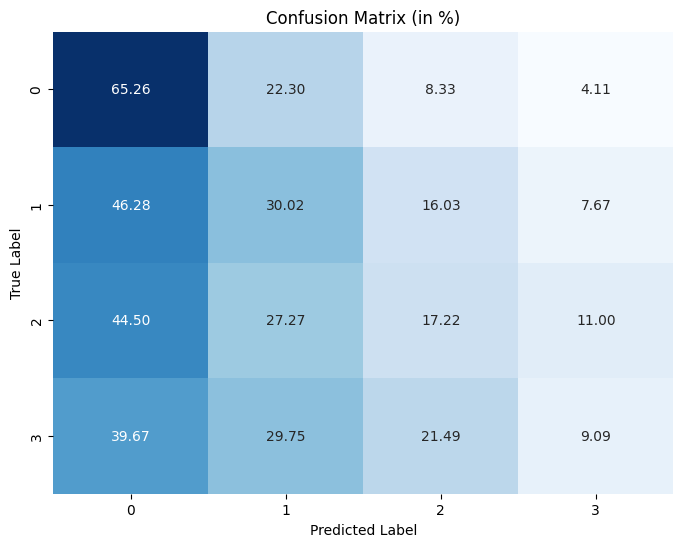

In [ ]:
import seaborn as sns
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
# print(classification_report(y_train_resampled, y_pred1))
# cm = confusion_matrix(y_train_resampled, y_pred1)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convertir en pourcentages
# Affichage de la matrice de confusion avec les pourcentages
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (in %)')
plt.show()

In [ ]:
out_1.loc["Random","meilleurs_parametres"]
with open('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/Random.pkl', 'wb') as Random:
    pickle.dump(out_1.loc["Random","best_model"], Random)

In [ ]:
y_pred

array([2, 3, 2, ..., 0, 0, 0])

In [ ]:
y_pred_series = pd.Series(y_pred, index= X_test1.index, name='y_pred')
y_test_series = pd.Series(y_test, index=X_test1.index, name='y_test')
a = pd.concat([X_test1[['id','CODEINTE_NUMEPOLI_CODERISQ','COUTS_SINISTRES']], y_test_series, y_pred_series], axis=1)
a.tail()

,id,CODEINTE_NUMEPOLI_CODERISQ,COUTS_SINISTRES,y_test,y_pred
3192,4083,2512 4010003785 1,216530.0,0,0
2377,4569,2545 4010002802 1,196403.0,0,1
5124,10461,4578 4000000044 24,125000.0,0,0
2242,392,4612 4010000046 1,87500.0,0,0
6384,13486,3918 4000000014 167,125000.0,0,0


In [ ]:
zero = a[a['y_test']==0]
liste = [1 if pred == lab else 0 for (pred, lab) in zip(list(zero['y_pred']),list(zero['y_test']))]
perf = sum(liste)/len(liste)
print(perf)

0.6525821596244131


In [ ]:
TP_zero = len(a[(a['y_test']==0) & (a['y_pred']==0)])
FP_zero = len(a[(a['y_pred']==0) & (a['y_test'] != 0)])
FN_zero = len(a[(a['y_pred'] != 0) & (a['y_test'] == 0)])
precision = TP_zero / (TP_zero + FP_zero)
recall = TP_zero / (TP_zero + FN_zero)
F1_score = 2*(precision*recall)/(precision+recall)
print(f'Précision: -------------- {precision}')
print(f'Recall: ------------- {recall}')
print(f'F1_score: ----------- {F1_score}')

Précision: -------------- 0.6164079822616408
Recall: ------------- 0.6525821596244131
F1_score: ----------- 0.6339794754846065


In [ ]:
# a['y_pred'].value_counts()

In [ ]:
2*(0.64*0.7)/(0.64+0.7)

0.6686567164179105

In [ ]:
b = pd.DataFrame({'True_label': y_test}, index=X_test.index)
c = pd.DataFrame({'Predict_label': list(y_pred)}, index=X_test.index)
d = pd.concat([X_test1[["id","CODEINTE_NUMEPOLI_CODERISQ","COUTS_SINISTRES"]], b, c], axis=1)

In [ ]:
d.tail()

,id,CODEINTE_NUMEPOLI_CODERISQ,COUTS_SINISTRES,True_label,Predict_label
3192,4083,2512 4010003785 1,216530.0,0,0
2377,4569,2545 4010002802 1,196403.0,0,1
5124,10461,4578 4000000044 24,125000.0,0,0
2242,392,4612 4010000046 1,87500.0,0,0
6384,13486,3918 4000000014 167,125000.0,0,0


In [ ]:
df = d.copy()
df = df.reset_index(drop=True)
df['Borne_inf'] = 500
df['Borne_sup'] = 333903
df['Moyenne'] = (500 + 333903)/2
for i in range(len(df)):
    if df.loc[i,'Predict_label'] == 1:
        df.loc[i, 'Borne_inf'] = 334000
        df.loc[i, 'Moyenne'] = (334000 + 725650)/2
        df.loc[i, 'Borne_sup'] = 725650
    if df.loc[i,'Predict_label'] == 2:
        df.loc[i, 'Borne_inf'] = 726000
        df.loc[i, 'Moyenne'] = (726000 + 1236650)/2
        df.loc[i, 'Borne_sup'] = 1236650
    if df.loc[i,'Predict_label'] == 3:
        df.loc[i, 'Borne_inf'] = 1236650
        df.loc[i, 'Moyenne'] = (1236650 + 1883000)/2
        df.loc[i, 'Borne_sup'] = 1883000

new_row = {col: '' for col in df.columns.difference(['Borne_inf', 'Borne_sup', 'Moyenne'])}
new_row['Borne_inf'] = df['Borne_inf'].sum()
new_row['Borne_sup'] = df['Borne_sup'].sum()
new_row['Moyenne'] = df['Moyenne'].sum()
new_row['COUTS_SINISTRES'] = df['COUTS_SINISTRES'].sum()

# # Ajouter la nouvelle ligne au DataFrame
df.loc['Total'] = new_row

In [ ]:
df.tail()

,id,CODEINTE_NUMEPOLI_CODERISQ,COUTS_SINISTRES,True_label,Predict_label,Borne_inf,Borne_sup,Moyenne
1621,4569,2545 4010002802 1,196403.0,0,1,334000,725650,529825.0
1622,10461,4578 4000000044 24,125000.0,0,0,500,333903,167201.5
1623,392,4612 4010000046 1,87500.0,0,0,500,333903,167201.5
1624,13486,3918 4000000014 167,125000.0,0,0,500,333903,167201.5
Total,,,748324334.0,,,414873950,1049276506,732075228.0


In [ ]:
df.to_csv('/opt/spark-apps/programs/Gohou/Data/Tabes/New_trans/pred.csv')

In [ ]:
a = df[df['Predict_label']==0]

In [ ]:
print(a['COUTS_SINISTRES'].sum())
print(a['Borne_inf'].sum())
print(a['Borne_sup'].sum())
print(a['Moyenne'].sum())

print(a['Borne_sup'].sum() / a['COUTS_SINISTRES'].sum())
# print(a['Moyenne'].sum()*0.75)

357386738.0
451000
301180506
150815753.0
0.8427299448363974


In [ ]:
df['True_label'].unique()

array([0, 2, 1, 3, ''], dtype=object)

In [ ]:
df['True_label'].value_counts()

True_label
0    852
1    443
2    209
3    121
       1
Name: count, dtype: int64

In [ ]:
print(a[a['True_label']==0]["COUTS_SINISTRES"].sum())
print(a[a['True_label']==1]["COUTS_SINISTRES"].sum())
print(a[a['True_label']==2]["COUTS_SINISTRES"].sum())
print(a[a['True_label']==3]["COUTS_SINISTRES"].sum())



print(a['COUTS_SINISTRES'].sum())
print(a['Borne_inf'].sum())
print(a['Borne_sup'].sum())
print(a['Moyenne'].sum())


98417885.0
99364756.0
87835177.0
71768920.0
357386738.0
451000
301180506
150815753.0


In [ ]:
# importances = out_1.loc['Random','best_model'].feature_importances_
# indices = np.argsort(importances)[::-1]  # Trier par importance décroissante
# top_features = indices[:10]

import numpy as np

# Trier les importances en ordre décroissant
importances = out_1.loc['Random','best_model'].feature_importances_
indices = np.argsort(importances)[::-1]
cumulative_importance = np.cumsum(importances[indices])

# Trouver le nombre de caractéristiques nécessaires pour atteindre 95% de l'importance
threshold = 0.70
n_features_important = np.argmax(cumulative_importance >= threshold) + 1

print(f"Nombre de caractéristiques nécessaires pour atteindre {threshold * 100}% de l'importance totale : {n_features_important}")

Nombre de caractéristiques nécessaires pour atteindre 70.0% de l'importance totale : 620


In [ ]:
top_features

array([  0,   1, 190,  47,   6,  11,   2, 580, 478, 599])

In [ ]:
384*3

1152

In [ ]:
512*4

2048

In [ ]:
1152 + 2048

3200

In [ ]:
512+511

1023

In [ ]:
2818 + 384

3202

In [ ]:
3201 -2818

383

In [ ]:
out_2 = out_1.copy()
# df = df.drop(index=[2, 5])

In [ ]:
out_2 = out_2.drop(index=['lightgbm', 'QDA', 'knn', 'elastic','catboost','Arbre','lasso'])
out_2.loc["Random","f1_score"] = 0.68563
out_2.loc["LDA","f1_score"] = 0.61453
out_2.loc["logistic","f1_score"] = 0.63345
out_2.loc["ridge","f1_score"] = 0.63356
out_2.loc["SVM","f1_score"] = 0.6654
out_2.loc["Bagging","f1_score"] = 0.6041
out_2.loc["adaboost_classifier","f1_score"] = 0.56462
out_2.loc["xgb","f1_score"] = 0.6724

out_2 = out_2.sort_values(by='f1_score', ascending=False)
out_2

,best_model,meilleurs_parametres,f1_score,temps
Random,"(DecisionTreeClassifier(max_depth=10, max_feat...","{'max_depth': 10, 'max_features': 0.8, 'min_sa...",0.68563,"[Wed Nov 13 10:53:13 2024, Fri Nov 15 15:37:47..."
xgb,"XGBClassifier(base_score=None, booster=None, c...","{'colsample_bytree': 0.7, 'max_depth': 3, 'n_e...",0.67240,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 16:14:00..."
SVM,"SVC(C=0.1, kernel='linear')","{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}",0.66540,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 13:23:13..."
ridge,"LogisticRegression(C=0.01, max_iter=10000, sol...","{'C': 0.01, 'max_iter': 10000, 'solver': 'sag'}",0.63356,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 12:55:47..."
logistic,"LogisticRegression(C=0.01, max_iter=10000)","{'C': 0.01, 'max_iter': 10000}",0.63345,"[Wed Nov 13 10:53:12 2024, Wed Nov 13 12:45:11..."
LDA,"LinearDiscriminantAnalysis(shrinkage='auto', s...","{'shrinkage': 'auto', 'solver': 'eigen'}",0.61453,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 12:00:59..."
Bagging,"(DecisionTreeClassifier(max_depth=7, random_st...","{'max_features': 0.5, 'max_samples': 0.6, 'n_e...",0.60410,"[Wed Nov 13 10:53:13 2024, Wed Nov 13 13:42:15..."
adaboost_classifier,"(DecisionTreeClassifier(max_depth=1, random_st...","{'algorithm': 'SAMME.R', 'learning_rate': 0.05...",0.56462,"[Wed Nov 13 10:53:13 2024, Thu Nov 14 21:22:26..."


In [ ]:
out_2[